In [24]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [25]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

In [26]:
import os

# Free up more GPU memory on the Jax and TensorFlow backends.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

In [27]:
#Downloading a portion of the C4 dataset
import keras
import pathlib
extract_dir = keras.utils.get_file(fname="mini-c4",origin=("https://hf.co/datasets/mattdangerw/mini-c4/resolve/main/mini-c4.zip"),extract=True,)
extract_dir = pathlib.Path(extract_dir) / "mini-c4"

In [28]:
#Let’s look at a document in our first shard:
with open(extract_dir / "shard0.txt", "r") as f:
     print(f.readline().replace("\\n", "\n")[:100])

Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You


In [29]:
#Downloading a SentencePiece vocabulary and instantiating a tokenizer
import keras_hub
import numpy as np
vocabulary_file = keras.utils.get_file(
origin="https://hf.co/mattdangerw/spiece/resolve/main/vocabulary.proto",)
tokenizer = keras_hub.tokenizers.SentencePieceTokenizer(vocabulary_file)

In [30]:
tokenizer.tokenize("The quick brown fox.")

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([  450,  4996, 17354,  1701, 29916, 29889], dtype=int32)>

In [31]:
tokenizer.detokenize([450, 4996, 17354, 1701, 29916, 29889])

'The quick brown fox.'

In [32]:
#Preprocessing text input for Transformer pretraining
import tensorflow as tf
batch_size = 128
sequence_length = 256
suffix = np.array([tokenizer.token_to_id("<|endoftext|>")])

def read_file(filename):
  ds = tf.data.TextLineDataset(filename)
  ds = ds.map(lambda x: tf.strings.regex_replace(x, r"\\n", "\n"))
  ds = ds.map(tokenizer, num_parallel_calls=8)
  return ds.map(lambda x: tf.concat([x, suffix], -1))

files = [str(file) for file in extract_dir.glob("*.txt")]
ds = tf.data.Dataset.from_tensor_slices(files)
ds = ds.interleave(read_file, cycle_length=32, num_parallel_calls=32)
ds = ds.rebatch(sequence_length + 1, drop_remainder=True)
ds = ds.map(lambda x: (x[:-1], x[1:]))
ds = ds.batch(batch_size).prefetch(8)

In [33]:
num_batches = 58746
num_val_batches = 500
num_train_batches = num_batches - num_val_batches
val_ds = ds.take(num_val_batches).repeat()
train_ds = ds.skip(num_val_batches).repeat()

In [ ]:
#Building the model

In [34]:
#A Transformer decoder block without cross-attention
from keras import layers

class TransformerDecoder(keras.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads):
        super().__init__()
        key_dim = hidden_dim // num_heads
        self.self_attention = layers.MultiHeadAttention(
        num_heads, key_dim, dropout=0.1
        )
        self.self_attention_layernorm = layers.LayerNormalization()
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.1)

    def call(self, inputs):
        residual = x = inputs
        x = self.self_attention(query=x, key=x, value=x, use_causal_mask=True)
        x = self.dropout(x)
        x = x + residual
        x = self.self_attention_layernorm(x)
        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = self.dropout(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x

In [35]:
# A positional embedding layer that can reverse a text embedding
from keras import ops

class PositionalEmbedding(keras.Layer):
    def __init__(self, sequence_length, input_dim, output_dim):
        super().__init__()
        self.token_embeddings = layers.Embedding(input_dim, output_dim)
        self.position_embeddings = layers.Embedding(sequence_length, output_dim)

    def call(self, inputs, reverse=False):
        if reverse:
            token_embeddings = self.token_embeddings.embeddings
            return ops.matmul(inputs, ops.transpose(token_embeddings))
        positions = ops.cumsum(ops.ones_like(inputs), axis=-1) - 1
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

In [36]:
# Creating a mini-GPT functional model
keras.config.set_dtype_policy("mixed_float16")

vocab_size = tokenizer.vocabulary_size()
hidden_dim = 512
intermediate_dim = 2056
num_heads = 8
num_layers = 8

inputs = keras.Input(shape=(None,), dtype="int32", name="inputs")
embedding = PositionalEmbedding(sequence_length, vocab_size, hidden_dim)
x = embedding(inputs)
x = layers.LayerNormalization()(x)
for i in range(num_layers):
    x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(x)
outputs = embedding(x, reverse=True)
mini_gpt = keras.Model(inputs, outputs)

In [11]:
#Pretraining the model

In [37]:
#Defining a custom learning rate schedule
class WarmupSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self):
        self.rate = 2e-4
        self.warmup_steps = 1_000.0

    def __call__(self, step):
        step = ops.cast(step, dtype="float32")
        scale = ops.minimum(step / self.warmup_steps, 1.0)
        return self.rate * scale

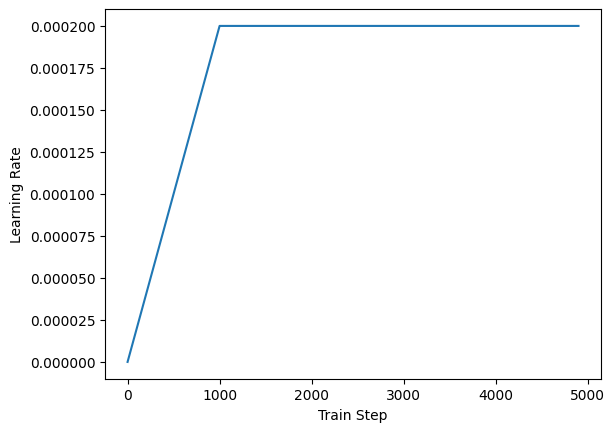

In [38]:
#We can plot our learning rate over time to make sure it is what we expect
import matplotlib.pyplot as plt
schedule = WarmupSchedule()
x = range(0, 5_000, 100)
y = [ops.convert_to_numpy(schedule(step)) for step in x]
plt.plot(x, y)
plt.xlabel("Train Step")
plt.ylabel("Learning Rate")
plt.show()

In [14]:
#Training the mini-GPT model

In [39]:
num_epochs = 8
steps_per_epoch = num_train_batches // num_epochs
validation_steps = num_val_batches

mini_gpt.compile(
    optimizer=keras.optimizers.Adam(schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
mini_gpt.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 935s 119ms/step - accuracy: 0.1854 - loss: 5.9557 - val_accuracy: 0.3104 - val_loss: 4.1544
Epoch 2/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 855s 117ms/step - accuracy: 0.3100 - loss: 4.1426 - val_accuracy: 0.3352 - val_loss: 3.9002
Epoch 3/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 853s 117ms/step - accuracy: 0.3304 - loss: 3.9329 - val_accuracy: 0.3481 - val_loss: 3.7702
Epoch 4/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 858s 118ms/step - accuracy: 0.3415 - loss: 3.8236 - val_accuracy: 0.3547 - val_loss: 3.7031
Epoch 5/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 853s 117ms/step - accuracy: 0.3469 - loss: 3.7669 - val_accuracy: 0.3600 - val_loss: 3.6513
Epoch 6/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 853s 117ms/step - accuracy: 0.3520 - loss: 3.7159 - val_accuracy: 0.3629 - val_loss: 3.6202
Epoch 7/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 853s 117ms/step - accuracy: 0.3546 - loss: 3.6910 - val_accuracy: 0.3655 - val_loss: 3.5933
Epoch 8/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 859s 118ms/step - accuracy: 

In [15]:
#Generative decoding

In [45]:
def generate(prompt, max_length=64):
    tokens = list(ops.convert_to_numpy(tokenizer(prompt)))
    prompt_length = len(tokens)
    for _ in range(max_length - prompt_length):
        prediction = mini_gpt(ops.convert_to_numpy([tokens]))
        prediction = ops.convert_to_numpy(prediction[0, -1])
        tokens.append(np.argmax(prediction).item())
    return tokenizer.detokenize(tokens)

In [46]:
prompt = "A piece of advice"
generate(prompt)

'A piece of advice for the public.\nThe first thing that I would like to do is to make sure that you have a good idea of what you want to do.\nIf you have a good idea of what you want to do, then you should make sure that you have a good idea of what you want'

In [47]:
# A compiled generation function for the mini-GPT model
def compiled_generate(prompt, max_length=64):
    tokens = list(ops.convert_to_numpy(tokenizer(prompt)))
    prompt_length = len(tokens)
    tokens = tokens + [0] * (max_length - prompt_length)
    for i in range(prompt_length, max_length):
        prediction = mini_gpt.predict(np.array([tokens]), verbose=0)
        prediction = prediction[0, i - 1]
        tokens[i] = np.argmax(prediction).item()
    return tokenizer.detokenize(tokens)

In [49]:
import timeit
tries = 10
timeit.timeit(lambda: compiled_generate(prompt), number=tries) / tries

5.0135613188998835

In [ ]:
# Sampling strategies

In [50]:
def compiled_generate(prompt, sample_fn, max_length=64):
    tokens = list(ops.convert_to_numpy(tokenizer(prompt)))
    prompt_length = len(tokens)
    tokens = tokens + [0] * (max_length - prompt_length)
    for i in range(prompt_length, max_length):
        prediction = mini_gpt.predict(np.array([tokens]), verbose=0)
        prediction = prediction[0, i - 1]
        next_token = ops.convert_to_numpy(sample_fn(prediction))
        tokens[i] = np.array(next_token).item()
    return tokenizer.detokenize(tokens)

In [51]:
# greedy search as a simple function we pass to compiled_generate():
def greedy_search(preds):
    return ops.argmax(preds)

compiled_generate(prompt, greedy_search)

'A piece of advice for the public.\nThe first thing that I would like to do is to make sure that you have a good idea of what you want to do.\nIf you have a good idea of what you want to do, then you should make sure that you have a good idea of what you want'

In [52]:
# we could sample this distribution directly
def random_sample(preds, temperature=1.0):
    preds = preds / temperature
    return keras.random.categorical(preds[None, :], num_samples=1)[0]

In [53]:
compiled_generate(prompt, random_sample)

'A piece of advice to cover the financial danger. Your organization must also work together to ensure that you “think” with a company that will provide the tax benefits. This may be a bit cumbersome, but actually it may not be a job that someone can satisfy. Specialized Insurance industry is one'

In [54]:
# setting temperature
from functools import partial
compiled_generate(prompt, partial(random_sample, temperature=2.0))

'A piece of adviceUpdated Women liveizer asset everythingromagnetatter الUND around Ralph Mooninc March publication vig wild luckPro sharingvarongo kom muex criendo Spain fans Luis initiuen Nationaleting Update scanrij Columbia Tierra which Business CC ourselves precise Guardian spher g fed rail stock vutherfunctions美 hatSIbt Science'

In [55]:
compiled_generate(prompt, partial(random_sample, temperature=0.8))

'A piece of advice is to procrastinate the ones you can remember from so that you could focus on them, not simply on what they are doing.\nThis is where Article 19 will come in to take in the kinds of news that happen to your organization. Discover any news that you have and'

In [56]:
compiled_generate(prompt, partial(random_sample, temperature=0.2))

'A piece of advice.\nI love the idea of a good friend, but I love the idea of a good friend.\nI love the idea of a good friend, but I love the idea of a good friend.\nI love the idea of a good friend, but I love the idea of a good friend'

In [57]:
# find the top K elements of an array
def top_k(preds, k=5, temperature=1.0):
    preds = preds / temperature
    top_preds, top_indices = ops.top_k(preds, k=k, sorted=False)
    choice = keras.random.categorical(top_preds[None, :], num_samples=1)[0]
    return ops.take_along_axis(top_indices, choice, axis=-1)

In [58]:
#few different variations of top-K to see how it affects sampling
compiled_generate(prompt, partial(top_k, k=5))

'A piece of advice is to make sure that you have the right equipment to ensure it’s safe.\nIf you have a problem with a piece of equipment or a large piece of equipment that you don’t like, then it’s time to make sure to contact an expert before you go.\nIf you'

In [59]:
compiled_generate(prompt, partial(top_k, k=20))

'A piece of advice. I can’t wait to see what you’ve done right now. I’ll be talking about a lot about what the new guidelines and the way that you should be.\nMy advice – you’ve got to do things you don’t like and do something you like'

In [60]:
#sampling the top five candidates with a temperature of 0.5:
compiled_generate(prompt, partial(top_k, k=5, temperature=0.5))

'A piece of advice that can help you with the process of getting the best results and to get the best results.\nIf you are a business owner and you are a professional in the field of business, then you can count on a professional to help you with the process.\nYou can be sure that you have the'